# Detecting individual trees from the LiDAR point cloud data
The primary task is to develop a pipeline for **detecting individual trees** from the LiDAR point
cloud data. The goal is to **identify the locations of tree tops** within the forest plots and compare
the detected trees with the ground truth field inventory data.

In [1]:
# necessary libraries
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import os
import math
import threading
import queue
import scipy
import random
from scipy import stats
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Normalize, Compose

data = os.getcwd()+"/data/"

# 1. Preprocess the Data

## Load the LiDAR point cloud data and normalize it if needed.

In [2]:
def check_is_aligned(xyplane,pval):  
    """based on the assumption that a plot that is not turned properly will not have a uniform spread of points along the x and y axes"""
    
    rows, columns = xyplane.shape
    rng = np.random.default_rng()
    px = stats.ks_2samp([x for x,y in xyplane],stats.uniform.rvs(size=rows, random_state=rng)).pvalue
    py = stats.ks_2samp([y for x,y in xyplane],stats.uniform.rvs(size=rows, random_state=rng)).pvalue
    p = min([px,py])
    return(p > pval)

def get_angle(x1,y1,x2,y2,x3,y3):
    """returns the angle between the line from (x1,y1) to (x2,y2) and the line from (x1,y1) to (x3,y3)"""

    a = [x3-x1,y3-y1]
    b = [x2-x1,y2-y1]
    la = math.sqrt(a[0]**2+a[1]**2)
    lb = math.sqrt(b[0]**2+b[1]**2)
    ab = a[0]*b[0]+a[1]*b[1]
    return(math.acos(ab/(la*lb)))

def lowest_4_indices(l):
    """l = list, returns the indices of the four lowest values"""

    lc = l.copy()
    v1 = min(lc)
    lc.remove(v1)
    v2 = min(lc)
    lc.remove(v2)
    v3 = min(lc)
    lc.remove(v3)
    v4 = min(lc)
    i1 = l.index(v1)
    i2 = l.index(v2)
    i3 = l.index(v3)
    i4 = l.index(v4)
    return([i1,i2,i3,i4])

def reorder(corners):
    """given four corners in a rectangle, reorders them to never have two successive points be diagonally opposed"""

    res = [corners[0]]                          #start with some corner
    l = len(corners)                            #to know how many corners we need to reorder
    corners = np.delete(corners,0,0)            #remove the first corner, so it is not found later on
    for i in range(1,l):
        KDT = scipy.spatial.KDTree(corners)
        ind = KDT.query(res[-1],k=1)[1]         #the closest remaining point to the last corner we found cannot be diagonally opposed to
        res += [corners[ind]]                   #the last corner
        corners = np.delete(corners,ind,0)      #remove the corner we found, to not obtain it again
    return(res)


def find_corners(xyplane):
    """xyplane = 2d numpy array
    supposes that this is a cloud in the shape of a diamond or rectangle, that is not aligned with the axes, and that has been
    normalised to [0,1]x[0,1]
    finds three of the corner points of this cloud, and angle in rad between the line between the first two corners, and the x-axis
    NOTE: this process supposes that the point cloud is sufficiently dense, and has no big outliers that could give a bad convex envelope,
    in the best case bad data will give a rough transformation, in the worst case the corners will be completely wrong"""
    
    #STEP 1: Find convex hull

    rng = np.random.default_rng()
    hull = ConvexHull(xyplane)                      
    hullpoints = np.asarray([[xyplane[x][0],xyplane[x][1]] for x in hull.vertices])     #points on the convex hull

    #--------------

    #STEP 2: Find all angles between points of the hull and their neighbours

    angles = []
    l = len(hullpoints)
    for i in range(l):
        xn,yn = hullpoints[(i+1)%l]
        xl,yl = hullpoints[(i-1)%l]
        x,y = hullpoints[i]
        angles += [get_angle(x,y,xl,yl,xn,yn)]

    #--------------

    #STEP 3: Find 4 points of the hull that have the lowest angle to their neighbours, as these are likely to be the corners

    indices = lowest_4_indices(angles)
    corners = reorder(hullpoints[indices])
    x1,y1 = corners[0]
    x2,y2 = corners[1]
    x3,y3 = corners[2]

    #--------------

    #Compute angle between the first two corners we found and the x axis

    d = math.sqrt((x2-x1)**2+(y2-y1)**2)
    alpha = math.acos((x2-x1)/d)

    #--------------

    return(x1,x2,x3,y1,y2,y3,alpha)

In [3]:
def rotate_point_2D(xc,yc,xp,yp,z,alpha):
    """xc,yc = coordinates of point to be rotated around
    xp,yp = coordinates of point to rotate
    alpha = angle in rad to rotate counter clockwise
    z = passthrough variable for ease of usage"""
    
    x = xc + math.cos(alpha) * (xp - xc) - math.sin(alpha) * (yp - yc)
    y = yc + math.sin(alpha) * (xp - xc) + math.cos(alpha) * (yp - yc)
    return [x,y,z]

def rotate_cloud(df,x1,y1,alpha):
    """df = dataframe with columns x,y,z (not plot!)
    rotates all points by alpha rad counter clockwise around the point (x1,y1) in the xy plane, leaves the 
    z coordinates unchanged. Returns a normalised dataframe with named columns"""

    vals = df.to_numpy()                                                #store values in an array for easy iteration
    vals_rotated = [rotate_point_2D(x1,y1,x,y,z,alpha) for x,y,z in vals]      #apply rotation around corner (x1,y1) by -alpha rad
                                                                        #note that the rotation is carried out in the xy plane and the 
                                                                        #z coordinates are left unchanged
    df_rotated = pd.DataFrame(vals_rotated).rename(columns={0: "x", 1: "y", 2: "z"})    #create new dataframe with the rotated points

    return(df_rotated)

def translate_cloud(df,x1,y1,x2,y2):
    """df = dataframe with columns x,y,z (not plot!)
    translates all points by a variable amount on the xy plane to align the left side of the diamond with the y axis
    leaves the z axis unchanged
    returns a normalised dataframe with named columns"""

    vals = df.to_numpy()

    #STEP 1: Find equation of side of the diamond

    m = (y2-y1)/(x2-x1)                                                 #get equation of line between (x1,y1) and (x3,y3)
    p = y1 - m                                                          #where y = mx + p

    #--------------

    #STEP 2: Substract the x values obtained from the line equation, renormalise and rename columns for consistency

    vals_shifted = [(x-(y-p)/m,y,z)for x,y,z in vals]                   #shift values to get a rectangle
    df_shifted = pd.DataFrame(vals_shifted).rename(columns={0: "x", 1: "y", 2: "z"})    #create new dataframe with translated points
 

    #--------------

    return(df_shifted)
   
def normalise_cloud(fielddf,lidardf,i,plot = False):
    """df = dataframe with columns x y and z (no column plot!)
        pval = p value to be used for kolmogorov smirnov test"""
    
    return_values = []

    #STEP 1: NORMALISE TO [0,1]x[0,1]

    lidardf = lidardf.rename(columns={0: "x", 1: "y", 2: "z"})        #rename columns
    fielddf = fielddf.rename(columns={"x": "x", "y": "y", "plot": "z"})     #otherwhise lidardf.min and max cannot be substracted from fielddf
                                                                            #the plot column will be broken by normalisation anyways and will thus be deleted and added back at the end

    fielddf = (fielddf-lidardf.min())/(lidardf.max()-lidardf.min())
    lidardf = (lidardf-lidardf.min())/(lidardf.max()-lidardf.min())   #linear normalisation to [0,1] of all coordinates

    lidarxyplane = lidardf.drop(columns = ["z"]).to_numpy()           #drop z axis as to normalise we use a "top down" view
    
    #--------------
    
    #Plotting

    if plot:
        fig, axs = plt.subplots(1,3)
        fig.set_figheight(5)
        fig.set_figwidth(15)

    #--------------

    #STEP 2: ROTATION TO ALIGN ONE SIDE OF CLOUD WITH AXIS

    #find three corners ((x1,y1) and (x3,y3) are diagonally opposed) and angle to rotate by

    x1,x2,x3,y1,y2,y3,alpha = find_corners(lidarxyplane)         #find 3 of the 4 corners needed for rotation and translation

    #--------------

    #Plotting

    if plot:

        X = [p[0] for p in lidarxyplane]
        Y = [p[1] for p in lidarxyplane]
        axs[0].set_title("After normalising to [0,1]x[0,1]")
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        axs[0].scatter(X,Y)
        axs[0].scatter([x1,x2,x3],[y1,y2,y3],marker = "X")

    #--------------

    #Rotation and normalisation

    xtest, ytest, filler = rotate_point_2D(x1,y1,x2,y2,0,alpha)     #compute rotation of one corner around other corner
    if (ytest < y1 + 0.05) and (ytest > y1 - 0.05):                 #if the two corners align by turning by alpha we turn 
        pass                                                        #the whole cloud by alpha
    else:
        xtest, ytest, filler = rotate_point_2D(x1,y1,x2,y2,0,-alpha)    #else we rotate by -alpha
        if (ytest < y1 + 0.05) and (ytest > y1 - 0.05):
            alpha = -alpha

    fielddf_rotated = rotate_cloud(fielddf,x1,y1,alpha)
    lidardf_rotated = rotate_cloud(lidardf,x1,y1,alpha) 

    fielddf_rotated = (fielddf_rotated-lidardf_rotated.min())/(lidardf_rotated.max()-lidardf_rotated.min())
    lidardf_rotated = (lidardf_rotated-lidardf_rotated.min())/(lidardf_rotated.max()-lidardf_rotated.min())   #linear normalisation to [0,1] of all coordinates

    #--------------

    #Retrieve new rotated corners
    
    i1 = lidardf.index[(lidardf['x'] == x1) & (lidardf['y'] == y1)].tolist()[0]        #get indexes of corners before transformations
    i2 = lidardf.index[(lidardf['x'] == x2) & (lidardf['y'] == y2)].tolist()[0]        #to easily get their values after the transformations
    i3 = lidardf.index[(lidardf['x'] == x3) & (lidardf['y'] == y3)].tolist()[0]

    x1,y1,z1 = lidardf_rotated.iloc[i1].to_numpy()                           #retrieve rotated and normalised corners
    x2,y2,z2 = lidardf_rotated.iloc[i2].to_numpy()
    x3,y3,z3 = lidardf_rotated.iloc[i3].to_numpy()

    #Plotting

    return_values += [x2,y2,x3,y3]

    if plot:
        vals_rotated = lidardf_rotated.to_numpy()                            #get array of rotated values for ease of plotting
        X = [p[0] for p in vals_rotated]
        Y = [p[1] for p in vals_rotated]
        axs[1].set_title("After rotation")
        axs[1].set_xlabel('x')
        axs[1].scatter(X,Y)
        axs[1].scatter([x1,x2,x3],[y1,y2,y3],marker = "X")

    #--------------

    #STEP 3: TRANSLATION TO ALIGN OTHER SIDE OF CLOUD WITH AXIS

    #Translation

    fielddf_shifted = translate_cloud(fielddf_rotated,x2,y2,x3,y3)
    lidardf_shifted = translate_cloud(lidardf_rotated,x2,y2,x3,y3)

    fielddf_shifted = (fielddf_shifted-lidardf_shifted.min())/(lidardf_shifted.max()-lidardf_shifted.min())
    lidardf_shifted = (lidardf_shifted-lidardf_shifted.min())/(lidardf_shifted.max()-lidardf_shifted.min())   #linear normalisation to [0,1] of all coordinates
    
    vals_shifted = lidardf_shifted.to_numpy()

    #--------------

    #Plotting

    if plot:
        X = [p[0] for p in vals_shifted]
        Y = [p[1] for p in vals_shifted]
        axs[2].set_title("After translation")
        axs[2].set_xlabel('x')
        axs[2].scatter(X,Y)
        fig.suptitle("Normalisation for plot " + str(i))
        plt.show()

    #--------------

    return(fielddf_shifted,lidardf_shifted)

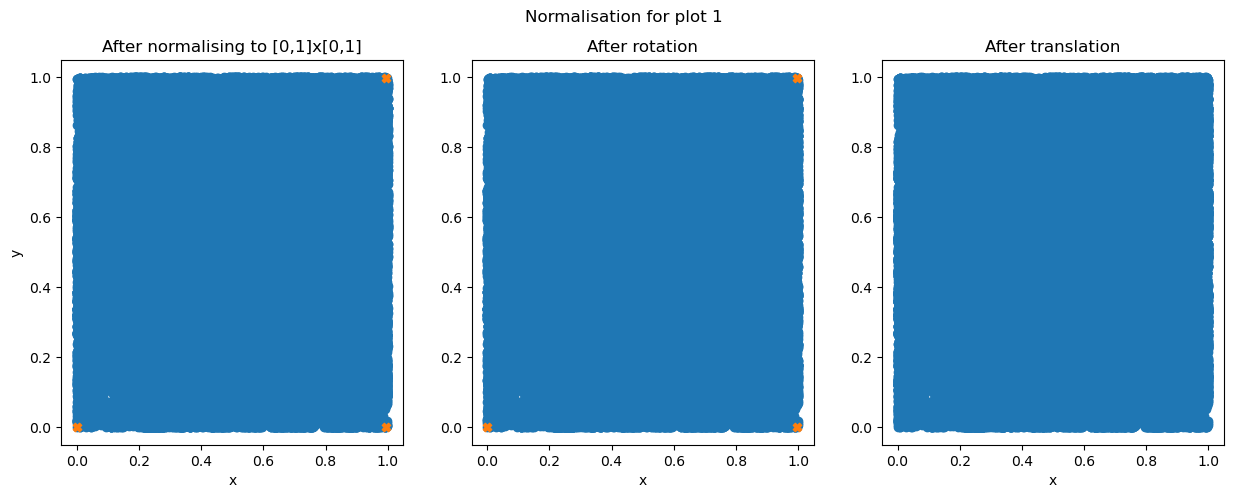

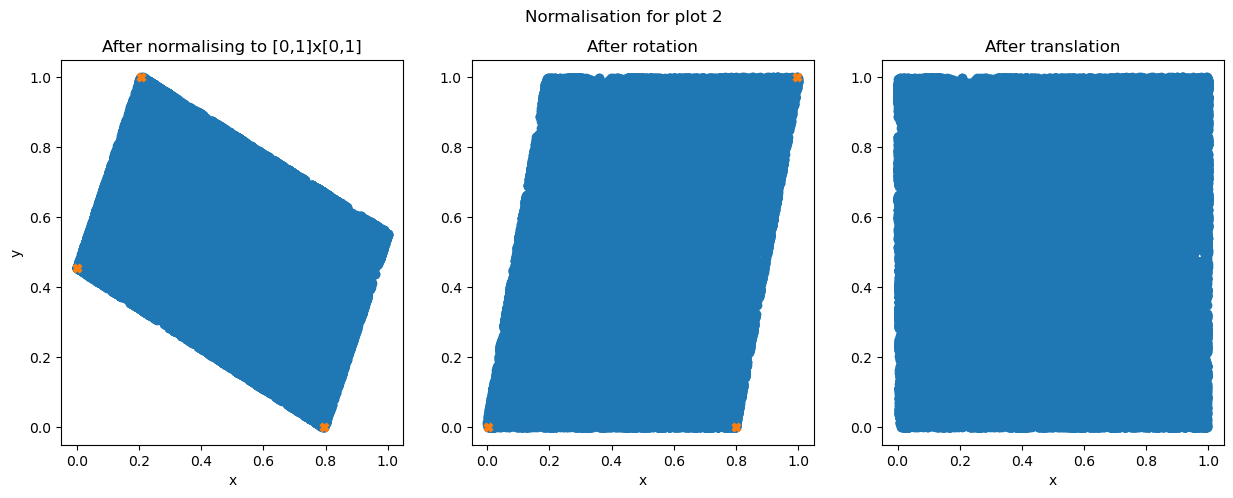

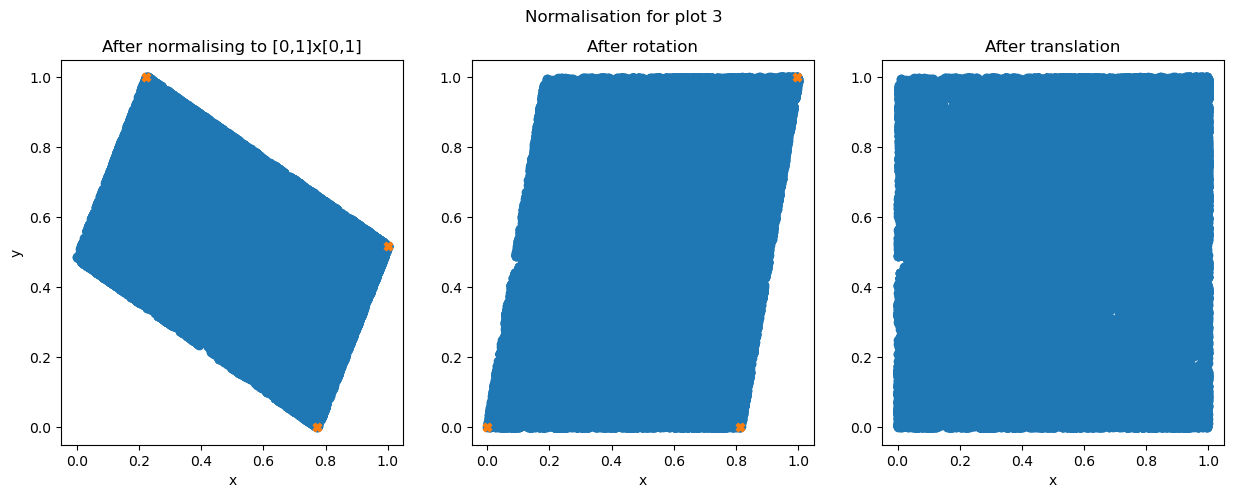

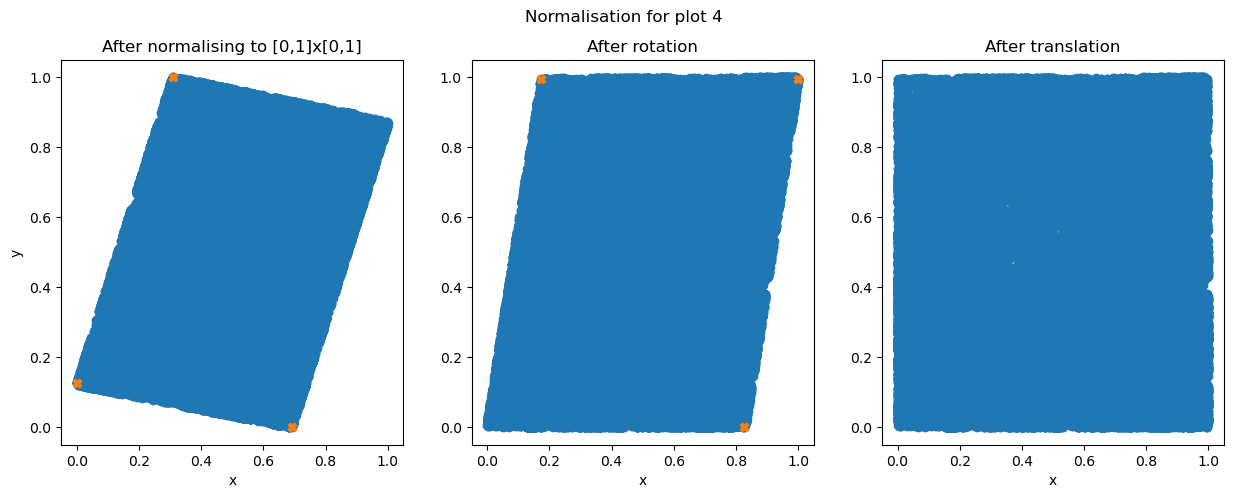

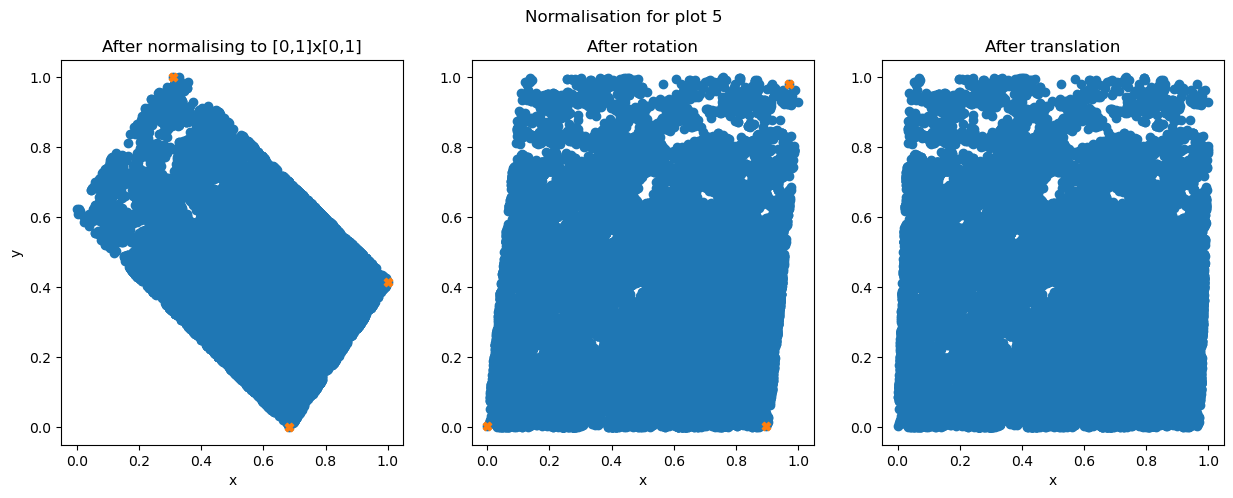

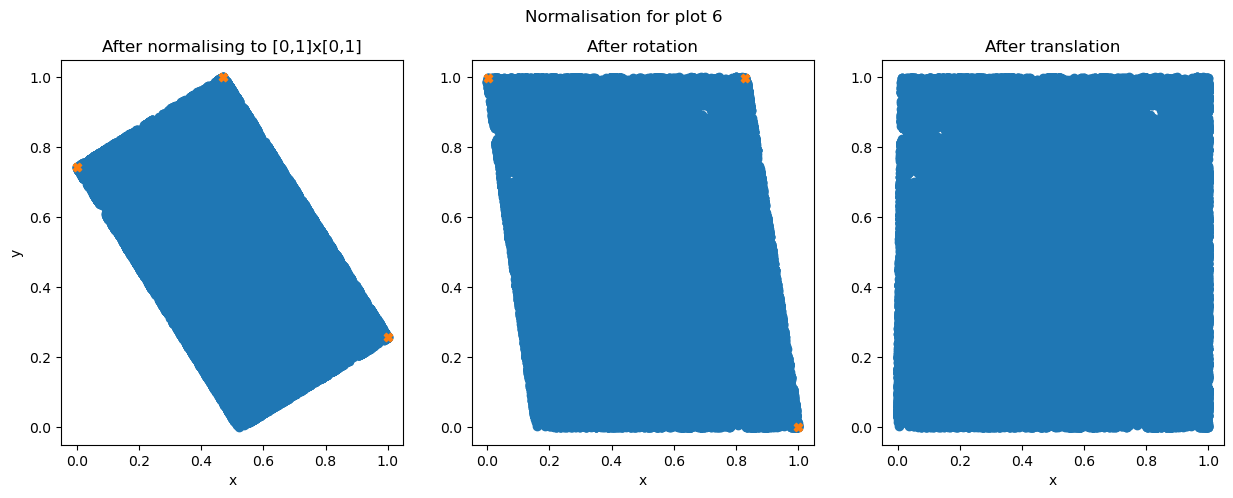

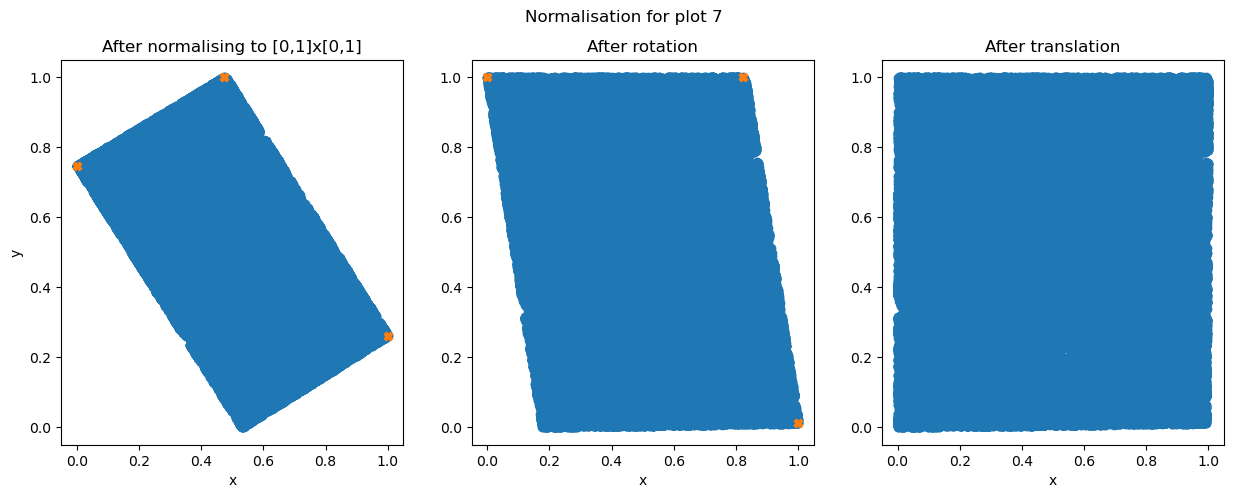

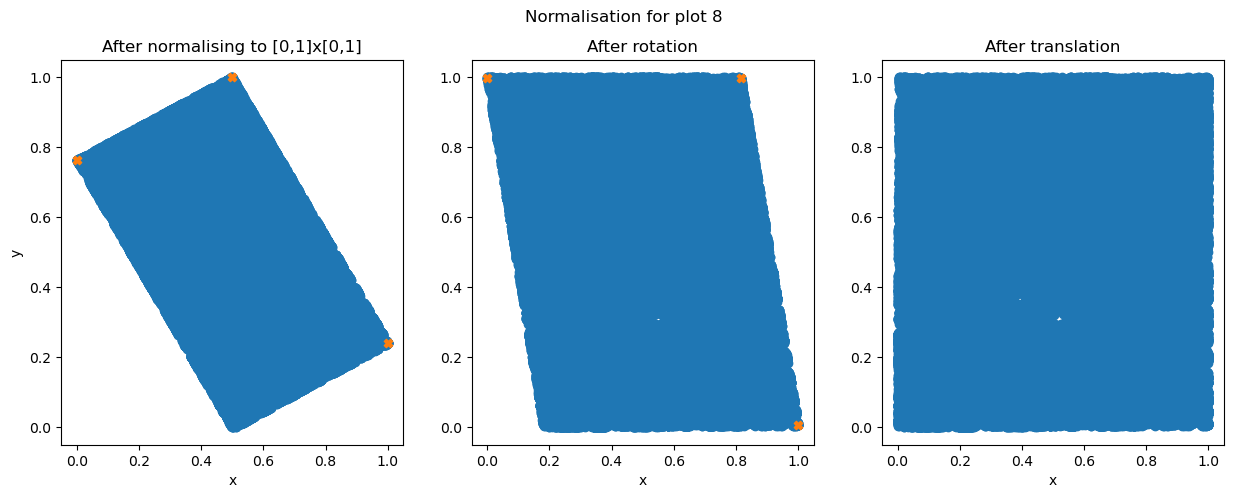

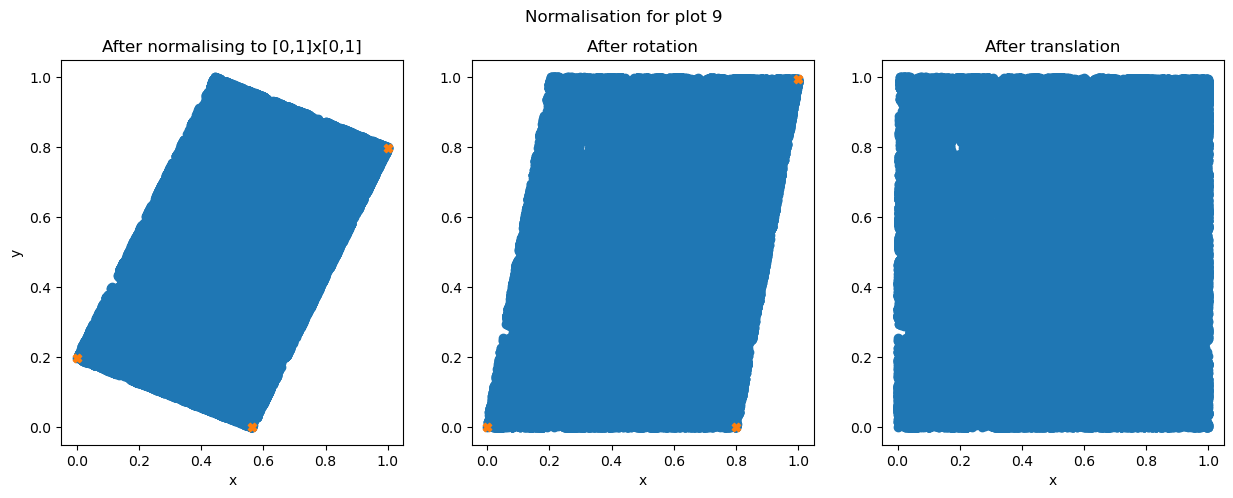

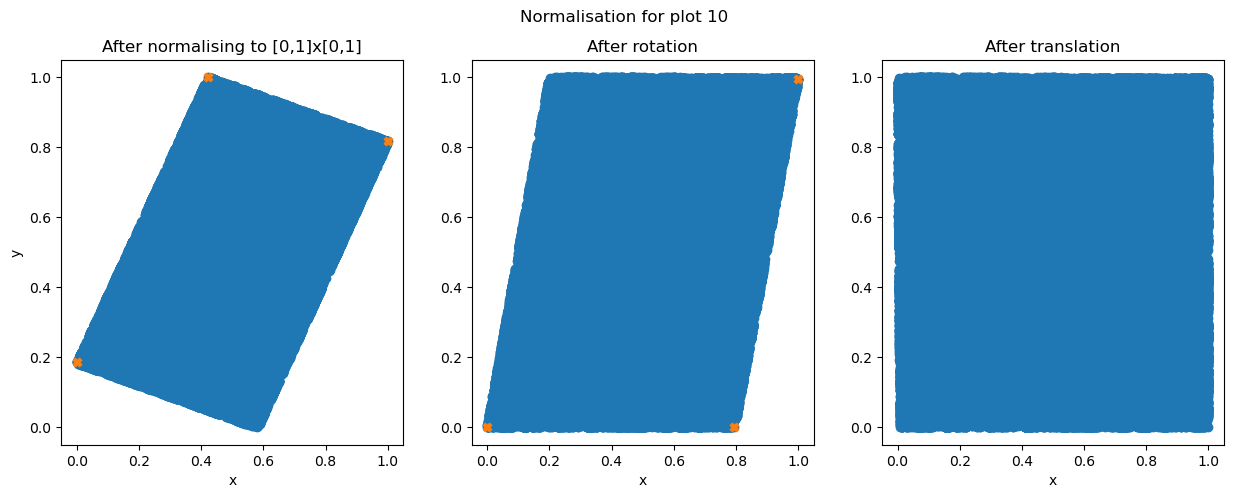

,tree_no,species,d1,d2,dbh,age,height,angle,comment,plot,x,y
0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,1,0.174021,0.927328
1,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,1,0.148773,0.875769
2,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,1,0.200486,0.879861
3,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,1,0.212895,0.871053
4,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,1,0.154845,0.839875
...,...,...,...,...,...,...,...,...,...,...,...,...
3592,517.0,Tilia,28.0,30.6,29.30,NaN,NaN,0.0,Two tops,10,0.138700,0.847022
3593,518.0,Fir,21.0,19.6,20.30,NaN,NaN,0.0,None,10,0.152168,0.855043
3594,519.0,Birch,32.1,31.0,31.55,NaN,NaN,80.0,Two tops,10,0.179963,0.874656
3595,520.0,Tilia,11.3,11.4,11.35,NaN,NaN,0.0,None,10,0.148210,0.887224


In [4]:
def load_lidar(indices,plot = False):
    """reads the .las files in succession, for each one normalises them into a square base, within 
    [0,1]x[0,1]x[0,1], puts all the (x,y,z) values into a dataframe, each with a number in the column plot
    corresponding to the file they were obtained from. The normalisation is done on a plot per plot basis.
    If plot = True, plots the normalisation process from a top down perspective"""
    with open(data+"field_survey.geojson") as f:
        field_survey = gpd.read_file(f)
    field_survey['x'] = field_survey["geometry"].apply(lambda x: x.coords[0][0])
    field_survey['y'] = field_survey["geometry"].apply(lambda x: x.coords[0][1])
    field_survey = field_survey.drop(columns=['geometry'])

    for i in indices:

        templidar = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz     #reads file as numpy array
        tempfielddf = field_survey.loc[field_survey['plot'] == i]
        lidartempdf = pd.DataFrame(templidar)                                       #converts numpy array to dataframe
        fieldtempdfxy = tempfielddf[['x','y','plot']]
        fieldtempdfxy, lidartempdf = normalise_cloud(fieldtempdfxy,lidartempdf,i,plot = plot)
        lidartempdf["plot"] = i                                                     #add column to store which file these points come from
        fieldx = np.asarray(fieldtempdfxy["x"])
        fieldy = np.asarray(fieldtempdfxy["y"])
        tempfielddf = tempfielddf.drop(columns = ['x','y','plot'])
        tempfielddf["plot"] = i  
        tempfielddf["x"] = fieldx
        tempfielddf["y"] = fieldy
        if i == 1:
            lidardf = lidartempdf
            fielddf = tempfielddf
        else:
            
            lidardf = pd.concat([lidardf,lidartempdf],ignore_index= True)
            fielddf = pd.concat([fielddf,tempfielddf],ignore_index= True)
    return(fielddf,lidardf)

fielddf,lidardf = load_lidar([i for i in range(1,11)],plot = True)

fielddf.head(-5)

Take a look at our point clouds

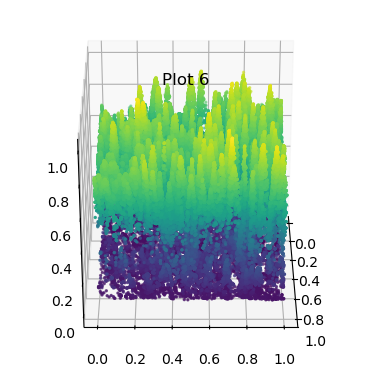

In [5]:
def plot_3d_cloud(df,i):
    #plot1 = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
    plot = df.loc[df["plot"] == i]
    plot = plot.drop(columns=['plot']).to_numpy()
    plot -= plot.min(axis=0, keepdims=True)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1, projection="3d")

    ax.scatter(
        *plot.swapaxes(0, 1),
        c=plot[:, 2],
        s=2,
    )

    ax.view_init(elev=30, azim=0)

    ax.set_title("Plot " + str (i), y=0.83)

    ax.set_aspect("equal")

plot_3d_cloud(lidardf,6)

## Filter irrelevant points (e.g., ground points below a height threshold) and remove residual noise.

In [6]:
def num_neigh(df,r):
    """df = dataframe cotaining the columns x y z and plot, for only one plot
    returns array containing the number of neighbours within radius r of all points"""
    KDT = scipy.spatial.KDTree(np.asarray(df.drop(columns=['plot'])))        #compute KDTree for fast computation
    arr = df.drop(columns=['plot']).to_numpy()                               #create array of (x,y,z) for iteration
    return([KDT.query_ball_point(point,r,workers = -1,return_length = True) for point in arr])

def dist_filter(df,r,a):
    """df = dataframe containing the columns x y z and plot, for all plots
    returns dataframe, where the points where the number of neighbours within radius r lie in the lower a quantile of the 
    number of neighbours are excluded"""
    iter = 0                                        #for iterative creation of dataframe
    for i in df["plot"].unique():                   #iterate through plots
        df_i = df.loc[df["plot"] == i]              #extract selected plot
        df_i["num_neigh"] = num_neigh(df_i,r)       #add column containing for each row the corresponding number of neighbours within r
        min_neigh = df_i.quantile(a)["num_neigh"]   #get quantile for number of neighbours
        df_i = df_i.loc[df_i["num_neigh"] >= min_neigh].drop(columns =["num_neigh"])
                                                    #drop every row with too few neighbours
        if iter == 0:                               #build dataframe iteratively
            res = df_i
            iter += 1
        else:
            res = pd.concat([res,df_i],ignore_index= True)
    return(res)

def load_and_filter(a1,a2,r1,r2):
    """ a1 = specifies which quantile to use to filter out lower points
        a2 = specifies which quantile to use to filter out points with few neighbours
        r1 = radius to check for neighbours for first filtering
        r2 = radius to check for neighbours for second filtering
        
        Returns dataframe where lower a1 quantile of points are filtered out (plot per plot), and
        applies two succesive radius based filters (plot per plot)"""

    fielddf, lidardf = load_lidar([i for i in range(1,11)],plot = False)

    #Filter out lower a quantile, where the quantiles are computed plot per plot
    #Otherwise, if the ground level is not the same for each plot we remove
    #inequally between the different plots

    for i in lidardf["plot"].unique():
        zQ = lidardf.loc[lidardf["plot"] == i].quantile(a1)["z"]               #compute height quantile of plot
        lidardf = lidardf.loc[-((lidardf["z"] < zQ) & (lidardf["plot"] == i))]      #remove low points from selected plot

    #--------------

    #Distance based filtering using KDTrees

    lidardf = dist_filter(dist_filter(lidardf,r1,a2),r2,a2)               #apply two filters successively, one rougher one finer

    #--------------

    return(fielddf,lidardf)

fielddf,lidardf = load_and_filter(a1 = 0.1, a2 = 0.05,r1 = 0.1,r2 =0.01)

C:\Users\Uni\AppData\Local\Temp\ipykernel_21788\1952850339.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i["num_neigh"] = num_neigh(df_i,r)       #add column containing for each row the corresponding number of neighbours within r
C:\Users\Uni\AppData\Local\Temp\ipykernel_21788\1952850339.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i["num_neigh"] = num_neigh(df_i,r)       #add column containing for each row the corresponding number of neighbours within r
C:\Users\Uni\AppData\Local\Temp\

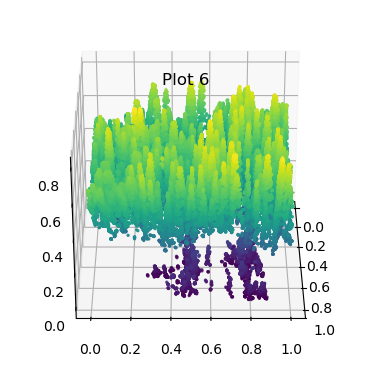

In [7]:
plot_3d_cloud(lidardf,6)

In [8]:
fielddf

,tree_no,species,d1,d2,dbh,age,height,angle,comment,plot,x,y
0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,1,0.174021,0.927328
1,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,1,0.148773,0.875769
2,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,1,0.200486,0.879861
3,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,1,0.212895,0.871053
4,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,1,0.154845,0.839875
...,...,...,...,...,...,...,...,...,...,...,...,...
3597,522.0,Fir,10.0,9.3,9.65,NaN,NaN,0.0,None,10,0.111749,0.872634
3598,523.0,Tilia,19.6,21.0,20.30,NaN,NaN,0.0,Two tops,10,0.141376,0.922360
3599,524.0,Fir,22.8,24.7,23.75,NaN,NaN,0.0,None,10,0.544474,0.797691
3600,525.0,Birch,23.3,23.1,23.20,NaN,NaN,0.0,None,10,0.592992,0.160549


## Partition the dataset into training and testing sets

In [9]:
def split_df_with_tree_positions_into_training_and_testing(df:pd.DataFrame,plot_number:int,test_size:float=0.2):
    """
    df = Dataframe with (x,y,plot) that repesents the actual position of the trees.
    plot_number = ground plot (100m x 50m) we are focusing on.
    test_size = percentage of the observation that belong to the test set.


    Returns two dataframes which represent the train and test data.
    """

    df_treedata_per_plot = df[df['plot']==plot_number][['x','y']] # get a dataframe with x and y coordinates, which reprent the tree psotions in the plot of land we are interested in 
    train_trees, test_trees = train_test_split(df_treedata_per_plot,test_size=test_size,random_state=42)
    return train_trees, test_trees


In [10]:

#train1,test1 = split_df_with_tree_positions_into_training_and_testing(fielddf,1)
#print(type(train1))
#print(train1)  

In [11]:
train_y_per_plot={} # 80% of total y (real position of trees)
test_y_per_plot={} # 20% of total y (real position of trees)
X_per_plot = {} # lidar_df data seperated by plot_number

for i in range(1,11):
    train, test = split_df_with_tree_positions_into_training_and_testing(fielddf,i)
    train_y_per_plot[i] = train 
    test_y_per_plot[i] = test
    X_per_plot[i] = lidardf[lidardf['plot']==i][['x','y','z']]



# 2. Implement and Extend Detection Algorithms

## Start with the provided local maxima filtering algorithm for baseline tree detection.

In [12]:
def local_maxima_filter(cloud: np.ndarray, window_size: float | int, height_threshold: float | int) -> np.ndarray:
    """Detect local maxima in the point cloud with a fixed window size."""
    
    assert isinstance(cloud, np.ndarray), f"Cloud needs to be a numpy array, not {type(cloud)}"
    
    cloud = cloud[cloud[:, 2] > height_threshold]
    tree = scipy.spatial.KDTree(data=cloud)
    seen_mask = np.zeros(cloud.shape[0], dtype=bool)
    local_maxima = []

    for i, point in enumerate(cloud):
        if seen_mask[i]:
            continue
        neighbor_indices = tree.query_ball_point(point, window_size)
        highest_neighbor = neighbor_indices[cloud[neighbor_indices, 2].argmax()]
        seen_mask[neighbor_indices] = True
        seen_mask[highest_neighbor] = False 
        # This may lead to not every point being marked as seed in the end, but it does not matter,
        # because by the time the seen value is overwritten the point is already processed
        if i == highest_neighbor:
            local_maxima.append(i)

    return cloud[local_maxima]

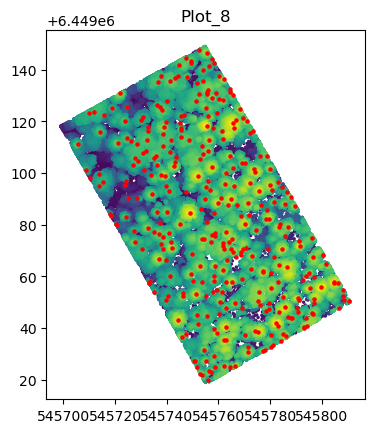

In [13]:
plot_number=8
las = laspy.read(data+"/als/plot_"+ "0"+ str(plot_number) + ".las")


local_maxima = local_maxima_filter(las.xyz, height_threshold=2, window_size=3)

# Sort by height to make top-down view look like a canopy height map
cloud = las.xyz[np.argsort(las.xyz[:, 2])]

fig, ax = plt.subplots()
ax.scatter(cloud[:, 0], cloud[:, 1], c=cloud[:, 2], s=2)
ax.scatter(local_maxima[:, 0], local_maxima[:, 1], c="red", s=5)
ax.set_title("Plot_"+str(plot_number))
ax.set_aspect("equal")



In [14]:
# export as vector 
potential_trees = gpd.GeoDataFrame(
    data={
        "height": local_maxima[:, 2],
    },
    geometry=gpd.GeoSeries.from_xy(*np.rollaxis(local_maxima, -1), crs=32640),
)

In [15]:
potential_trees.head()

,height,geometry
0,169.639,POINT Z (545808.161 6449054.765 169.639)
1,165.736,POINT Z (545800.514 6449068.365 165.736)
2,169.460,POINT Z (545780.818 6449093.595 169.460)
3,162.650,POINT Z (545779.751 6449049.680 162.650)
4,170.986,POINT Z (545784.881 6449037.793 170.986)


## Convert the point cloud into 2D slices (e.g., horizontal or vertical cross-sectional images) and apply a deep learning model such as ResNet or UNet to identify individual trees.

In [16]:
def create_2D_slices_per_plot(dict_df: dict, slice_width: float, plot_number: int, axis: str = 'x'):
    """
    Parameters:
    dict_df = Dictionary containing dataframes of all LiDAR points from a plot of land. (e.g. dict_df[1] dataframe for plot 1)
    slice_width = The width of the 2D slice in terms of the x or y coordinate
    plot_number = Plot of land we focus on
    axis = The axis along which to create the vertical slices ('x' or 'y' or 'z')

    Returns the sliced data in a single dataframe.
    """
    lidar_data = dict_df[plot_number]
    min_coord = lidar_data[axis].min()
    max_coord = lidar_data[axis].max()
    #on the z axis the coordinates no longer necessarily cover [0,1] because of the filtering
    #the same holds for x and y but is far less likely due to the way the data was filtered

    # Generate 2D slices
    slices = []
    coords = np.arange(min_coord, max_coord, slice_width)
    for i, coord in enumerate(coords):
        slice_data = lidar_data[
            (lidar_data[axis] >= coord) & (lidar_data[axis] < coord + slice_width)
        ]
        slice_data['slice_level'] = i  # Label the slice
        slices.append(slice_data)
        
    # Combine all slices into a single dataframe
    sliced_data = pd.concat(slices)
    return sliced_data


In [18]:
def create_2D_slices(slice_width: float, X_per_plot: dict, axis: str = 'z'):
    """
    Create 2D slices of LiDAR data for each plot.

    Parameters:
    slice_value (float): The thickness or width of the 2D slices (depending on the axis).
    X_per_plot (dict): A dictionary where keys are plot numbers and values are LiDAR dataframes for each plot.
    axis (str): The axis along which to create slices ('x', 'y', or 'z'). Default is 'z'.

    Returns:
    dict: A dictionary where keys are plot numbers and values are dataframes containing 2D slices for each plot.
    """
    # Validate the axis parameter
    if axis not in ['x', 'y', 'z']:
        raise ValueError("Invalid axis. Expected 'x', 'y', or 'z'.")
    
    # Initialize a dictionary to store the sliced data for each plot
    X_per_plot_sliced = {}

    # Iterate over each plot in the input dictionary
    for plot in X_per_plot.keys():  # Dynamically handle plot numbers
        
        # Create vertical slices along the specified axis ('x' or 'y' or 'z')
        X_per_plot_sliced[plot] = create_2D_slices_per_plot(
            X_per_plot, slice_width=slice_width, plot_number=plot, axis=axis
        )
    
    # Return the dictionary containing sliced data for all plots, key = plot number, value = dataframe containing the sliced data
    return X_per_plot_sliced


In [ ]:
X_slices_df_per_plot = create_2D_slices(0.1,X_per_plot,axis = 'x')

In [ ]:
X_slices_df_per_plot

In [19]:

def convert_slices_to_images(slices_dict: dict, output_dir: str, grid_size: float = 0.01):
    """
    Convert 2D slices into images and save them to disk.

    Parameters:
    slices_dict (dict): A dictionary where keys are plot numbers and values are dataframes containing 2D slices.
    output_dir (str): Directory to save the generated images.
    grid_size (float): The size of each grid cell in the 2D image (default is 0.01).

    Returns:
    None
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each plot's sliced data
    for plot, slice_data in slices_dict.items():
        # Group slices by slice level
        grouped = slice_data.groupby('slice_level')
        
        for slice_level, group in grouped:
            # Extract x and y coordinates for the current slice
            x = group['x']
            y = group['y']
            
            # Create a 2D histogram for the slice
            hist, xedges, yedges = np.histogram2d(
                x, y, bins=int(1 / grid_size)
            )
            
            # Normalize the histogram (optional, for better visualization)
            hist = hist / np.max(hist) if np.max(hist) > 0 else hist
            
            # Save the histogram as an image
            plt.figure(figsize=(10, 10))
            plt.imshow(hist.T)
            #plt.colorbar(label="Point Density")
            #plt.title(f"Plot {plot} - Slice {slice_level}")
            #plt.xlabel("X Coordinate")
            #plt.ylabel("Y Coordinate")
            plt.axis('off')
            
            # Save the image to the output directory
            image_path = os.path.join(output_dir, f"plot_{plot}_slice_{slice_level}.png")
            plt.savefig(image_path, bbox_inches='tight')
            plt.close()



In [20]:
import warnings
warnings.filterwarnings('ignore')

# create dictionary of 2D slice dataframes
# Ideas for later
# for later we can experiment with different slice values
# we can use vertical slices like 'x' or 'y' direction instead of 'z'
X_slices_df_per_plot = create_2D_slices(0.2,X_per_plot,axis = 'z')
slice_dir = data+"slices"
# we change the grid size later to something different than 0.01
convert_slices_to_images(X_slices_df_per_plot,slice_dir)


In [ ]:
def plot_slices(slice_width: float, X_per_plot: dict, axis: str = 'z'):
    dict_per_plot = create_2D_slices(slice_width,X_per_plot,axis)
    dirs = ['x','y','z']
    dirs.remove(axis)
    for plot in dict_per_plot.keys():
        df = dict_per_plot[plot]
        for slice in df["slice_level"].unique():
            temp = (df[df["slice_level"] == slice])[dirs]
            x = temp[dirs[0]]
            y = temp[dirs[1]]
            plt.scatter(x,y)
            plt.title("Plot = " + str(plot) + " | Slice = " + str(slice))
            plt.xlabel(dirs[0])
            plt.ylabel(dirs[1])
            plt.show()

plot_slices(0.1,X_per_plot,'z')

In [44]:
def create_ground_truth_masks(train_y_per_plot, slices_dict, grid_size=0.01):
    """
    Generate binary masks for U-Net training.

    Parameters:
    train_y_per_plot (dict): Dictionary of tree positions for training plots.
    slices_dict (dict): Dictionary of slices for training plots.
    grid_size (float): The size of each grid cell in the mask.

    Returns:
    dict: Dictionary of ground truth masks for each slice.
    """
    masks = {}
    for plot, tree_positions in train_y_per_plot.items():
        # Get the corresponding slices
        slice_data = slices_dict[plot]
        slice_groups = slice_data.groupby('slice_level')

        # Generate masks for each slice
        masks[plot] = {}
        for slice_level, group in slice_groups:
            x = group['x']
            y = group['y']

            # Generate an empty mask grid
            grid_size_x = int(1 / grid_size)
            grid_size_y = int(1 / grid_size)
            mask = np.zeros((grid_size_x, grid_size_y))

            # Populate the mask with tree positions
            for _, tree in tree_positions.iterrows():
                grid_x = int(tree['x'] / grid_size)
                grid_y = int(tree['y'] / grid_size)
                mask[grid_x, grid_y] = 1  # Mark the tree position
            
            masks[plot][slice_level] = mask
    return masks

train_masks = create_ground_truth_masks(train_y_per_plot, X_slices_df_per_plot, grid_size=0.01)
print(type(train_masks))

<class 'dict'>


In [45]:
from PIL import Image

def prepare_data_for_unet(image_dir, mask_dict, target_size=(400, 400)):
    """
    Load image slices and corresponding masks for U-Net training, resizing them to match the target dimensions.
    
    Parameters:
    image_dir (str): Directory containing the saved images.
    mask_dict (dict): Dictionary containing ground truth masks.
    target_size (tuple): Target size (height, width) for resizing.

    Returns:
    tuple: (images, masks) as numpy arrays.
    """
    images = []
    masks = []
    for plot, slices in mask_dict.items():
        for slice_level, mask in slices.items():
            # Load and resize image
            image_path = os.path.join(image_dir, f"plot_{plot}_slice_{slice_level}.png")
            if os.path.exists(image_path):
                image = Image.open(image_path).convert('L')
                image = image.resize(target_size)  # Resize image
                images.append(np.array(image).astype(np.float32) / 255.0)  # Convert to float32 and normalize

                # Resize mask to the same target size
                resized_mask = Image.fromarray(mask).resize(target_size)
                masks.append(np.array(resized_mask).astype(np.float32) / 255.0)  # Convert to float32 and normalize
            else:
                print(f"Image not found: {image_path}")

    images = np.expand_dims(np.array(images), axis=1)  # Add channel dimension
    masks = np.expand_dims(np.array(masks), axis=1)  # Add channel dimension

    return images, masks


train_images, train_masks = prepare_data_for_unet(slice_dir, train_masks)


In [46]:
print(train_masks.shape)
print(train_images.shape)

(76, 1, 400, 400)
(76, 1, 400, 400)


In [47]:
# Define the U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Contracting Path
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        # Expanding Path
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),  # Concatenation adds channels
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Contracting Path
        enc1 = self.enc1(x)  # Feature map from encoder
        x = self.pool1(enc1)

        # Expanding Path
        x = self.up1(x)  # Upsample
        x = torch.cat([x, enc1], dim=1)  # Concatenate skip connection
        x = self.dec1(x)

        return x

# Dataset Class for Images and Masks
class LiDARDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


In [48]:
from sklearn.model_selection import train_test_split

# Transform to normalize and convert to PyTorch tensor
transform = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])

# Split train and validation data
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Create Dataset and DataLoader
train_dataset = LiDARDataset(train_images, train_masks, transform=transform)
val_dataset = LiDARDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [49]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy for segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        print("Image shape to model:", images.shape)
        print("Masks shape to model:", masks.shape)
        if images.ndim == 4 and images.shape[2] == 1:  # Check if channel is in the wrong position
            images = images.permute(0, 2, 1, 3)  # Rearrange to [batch_size, 1, height, width]

        if masks.ndim == 4 and masks.shape[2] == 1:  # Check if channel is in the wrong position
            masks = masks.permute(0, 2, 1, 3)  # Rearrange to [batch_size, 1, height, width]    
        print("Image shape to model:", images.shape)
        print("Masks shape to model:", masks.shape)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

Image shape to model: torch.Size([8, 400, 1, 400])
Masks shape to model: torch.Size([8, 400, 1, 400])
Image shape to model: torch.Size([8, 1, 400, 400])
Masks shape to model: torch.Size([8, 1, 400, 400])


RuntimeError: all elements of target should be between 0 and 1